# Vertex Pipelines: Anomaly Detection Prediction using custom Classification Model

## Overview

The example uses the UCI Machine Learning [AI4I 2020 Predictive Maintenance Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset) from Stephan Matzka, School of Engineering - Technology and Life, Hochschule fü Technik und Wirtschaft Berlin, 12459 Berlin, Germany.



### Dataset

The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

### Objective

In this example, you'll learn how to use components from `google_cloud_pipeline_components` to:
- create a _Dataset_ using data in cloud storage
- train an Custom AI model
- deploy the trained model to an _endpoint_ for serving


### Set up your  development environment

**Please note that the environment for the following notebook steps can be run on Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook.

## Before you begin

This notebook does not require a GPU runtime.



**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Install additional packages, Ignore any errors that occur during installing packages



In [ ]:

import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q
! pip3 install -U google-cloud-storage $USER_FLAG -q
! pip3 install $USER kfp google-cloud-pipeline-components --upgrade -q
! pip3 install  xgboost==1.2 

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6. 


** If this step takes a long time to execute, then from the menu on the top, goto Kernel --> Restart Kernel*

In [ ]:
#test the version of Kfp - should be >= 1.6

import kfp
print('KFP SDK version: {}'.format(kfp.__version__))

In [ ]:
import uuid

import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


import kfp
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import compiler
from kfp.v2.google.client import AIPlatformClient
from kfp.v2 import compiler
from kfp.v2.dsl import component
from kfp.v2.google import experimental
from kfp.v2.google.client import AIPlatformClient

Check your project_id in the cell below, if you don't see an output with a project id - then you will set it up in the next step. 

In [ ]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)


Ignore the cell below if you see the project id - Otherwise, set your project ID here below. Replace "CHANGE_THIS" to your project_id

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "<CHANGE_THIS>"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Train XGBoost Classification Model




In [ ]:
COLUMN_NAMES = collections.OrderedDict({
 'udi': np.int8,
 'Product ID': 'category',
 'Type': 'category',
 'air_temperature_k': np.float64,
 'process_temperature_k': np.float64,
 'rotational_speed_rpm': np.float64,
 'torque_nm': np.float64,
 'tool_wear_min':  np.int8,
 'machine_failure': np.int8,
 'TWF': np.int8,
 'HDF': np.int8,
 'PWF': np.int8,
 'OSF': np.int8,
 'RNF': np.int8

})

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv

In [ ]:
data = pd.read_csv(
 'ai4i2020.csv',
 index_col=False,
 dtype=COLUMN_NAMES
)
data = data.dropna()
data = shuffle(data, random_state=2)
data.head()

In [ ]:
# Class labels - 0: denied, 1: approved
print(data['Machine failure'].value_counts())

labels = data['Machine failure'].values

data = data.drop(columns=['Machine failure'])

In [ ]:
dummy_columns = list(data.dtypes[data.dtypes == 'category'].index)
data = pd.get_dummies(data, columns=dummy_columns)


data.head()


In [ ]:
data.info()

In [ ]:
x,y = data.values,labels
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [ ]:
anomaly_model = xgb.XGBClassifier(
    objective='reg:logistic'
)

In [ ]:
anomaly_model.fit(x_train, y_train)

In [ ]:
#BUCKET_NAME = "gs://project849089-bucket/vai"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "gs://" + PROJECT_ID + "-vertex-ai" 
MODEL_NAME = 'xgb_anomaly_detection'

print("Bucket name: ", BUCKET_NAME)


In [ ]:
y_pred = anomaly_model.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print(acc, '\n')

In [ ]:
anomaly_model.save_model('model.bst')

In [ ]:
!gsutil mb -l us-central1 $BUCKET_NAME

In [ ]:
!gsutil cp ./model.bst $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents. You should the model.bst.

In [ ]:
! gsutil ls -al $BUCKET_NAME

## Setting up Service Account**



Once the Vertex AI API is enabled, you will be taken to the Vertex-AI API properties page. Alternatively, you can click on the “Manage” button to reach here.


From the left side of the screen, click on “Credentials” and make a note of the service account of the compute service account. This service account will be used to grant access to the bucket from the Vertex AI notebooks in the next few steps.
For e.g. It will look something like this
"1023279203633-compute@developer.gserviceaccount.com"

In [ ]:
# you can get this from the Vertex AI API Credentials page, it will be something like this [account]-compute@developer.gserviceaccount.com 
#for e.g. service_account = '1023279203633-compute@developer.gserviceaccount.com'

service_account = '405932577923-compute@developer.gserviceaccount.com'  # <<- Please change this to service account copied earlier


In [ ]:
!gsutil iam ch serviceAccount:$service_account:roles/storage.admin $BUCKET_NAME

### Import libraries and define constants

Define some constants. 


In [ ]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

USER = "xgb_anomaly_model"  
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)

PIPELINE_ROOT

## Define a custom model pipeline that uses components from google_cloud_pipeline_components

Define the pipeline:

Pipeline module consists of 2 tasks / operations: 

1- **Create a Model task:** A Model created under the Model section of the Vertex AI 

2- **Create an EndPoint task:** Crete an endpoint

3- **Model deploy task:** Model deployment task with project name and machine_type. Please note that the parameter machine_type is mandatory.

Set some variables that will be used in constructing the args passed to the custom training job and setting pipeline params.

In [ ]:
REGION = "us-central1"  # @param {type:"string"}
#BUCKET_NAME = "gs://" + PROJECT_ID + "_vertexai_" + TIMESTAMP
MODEL_NAME = 'xgb-anomaly-detection-model'
MACHINE_TYPE = "n1-standard-4"

Set some variables that will be used in constructing the args passed to the custom training job and setting pipeline params.

Next, you define a component with which the custom training job is run.  For this example, this component doesn't do anything (but run a print statement).

Now, you define the pipeline.  

Then, [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) components are used to define the rest of the pipeline: upload the model, create an endpoint, and deploy the model to the endpoint. (While not shown in this example, the model deploy will create an endpoint if one is not provided.)

In [ ]:
@kfp.dsl.pipeline(name="xgb-anomaly-detection-model" + str(uuid.uuid4()))
def pipeline(
    project: str = PROJECT_ID,
    model_display_name: str = MODEL_NAME,
    serving_container_image_uri: str = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-3:latest',
):

 

    model_upload_op = gcc_aip.ModelUploadOp(
        project=project,
        display_name=model_display_name,
        artifact_uri=BUCKET_NAME,
        serving_container_image_uri=serving_container_image_uri,
    )


    endpoint_create_op = gcc_aip.EndpointCreateOp(
        project=project,
        display_name="pipelines-created-endpoint",
    )

    model_deploy_op = gcc_aip.ModelDeployOp(  
        endpoint=endpoint_create_op.outputs["endpoint"],
        model=model_upload_op.outputs["model"],
        deployed_model_display_name=model_display_name,
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=1,
        dedicated_resources_machine_type=MACHINE_TYPE,
    )

## Compile and run the pipeline

Now, you're ready to compile the pipeline:

The pipeline compilation generates the `train_whatif_model.json` job spec file.

Next, instantiate an API client object:

In [ ]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="xgb_anomaly_detection_model.json"
)

In [ ]:
print(PROJECT_ID, BUCKET_NAME, REGION) 

** Please note that you might get a FutureWarning, after running this cell below. please ignore. 

In [ ]:
from kfp.v2.google.client import AIPlatformClient  # noqa: F811

api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

Then, you run the defined pipeline like this: (The pipeline may take 10-12 minutes to run)

Running the cell below will provide you a link that shows the status of the pipeline being run. Please click on the link to see the pipeline, as shown in the screenshot below.

In [ ]:
response = api_client.create_run_from_job_spec(
    "xgb_anomaly_detection_model.json",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID},
)

Click on the generated link to see your run in the Cloud Console.  It should look something like this:

You can also try clicking on the "Expanded Artifacts" toggle button on the top. 



## Observe

Observe the corresponding entries in the pipeline and models section from the Vertex AI interface.



In this example, you learnt how to use components from `google_cloud_pipeline_components` to:

- create a _Dataset_ using data in cloud storage
- train an Custom AI model
- deploy the trained model to an _endpoint_ for serving


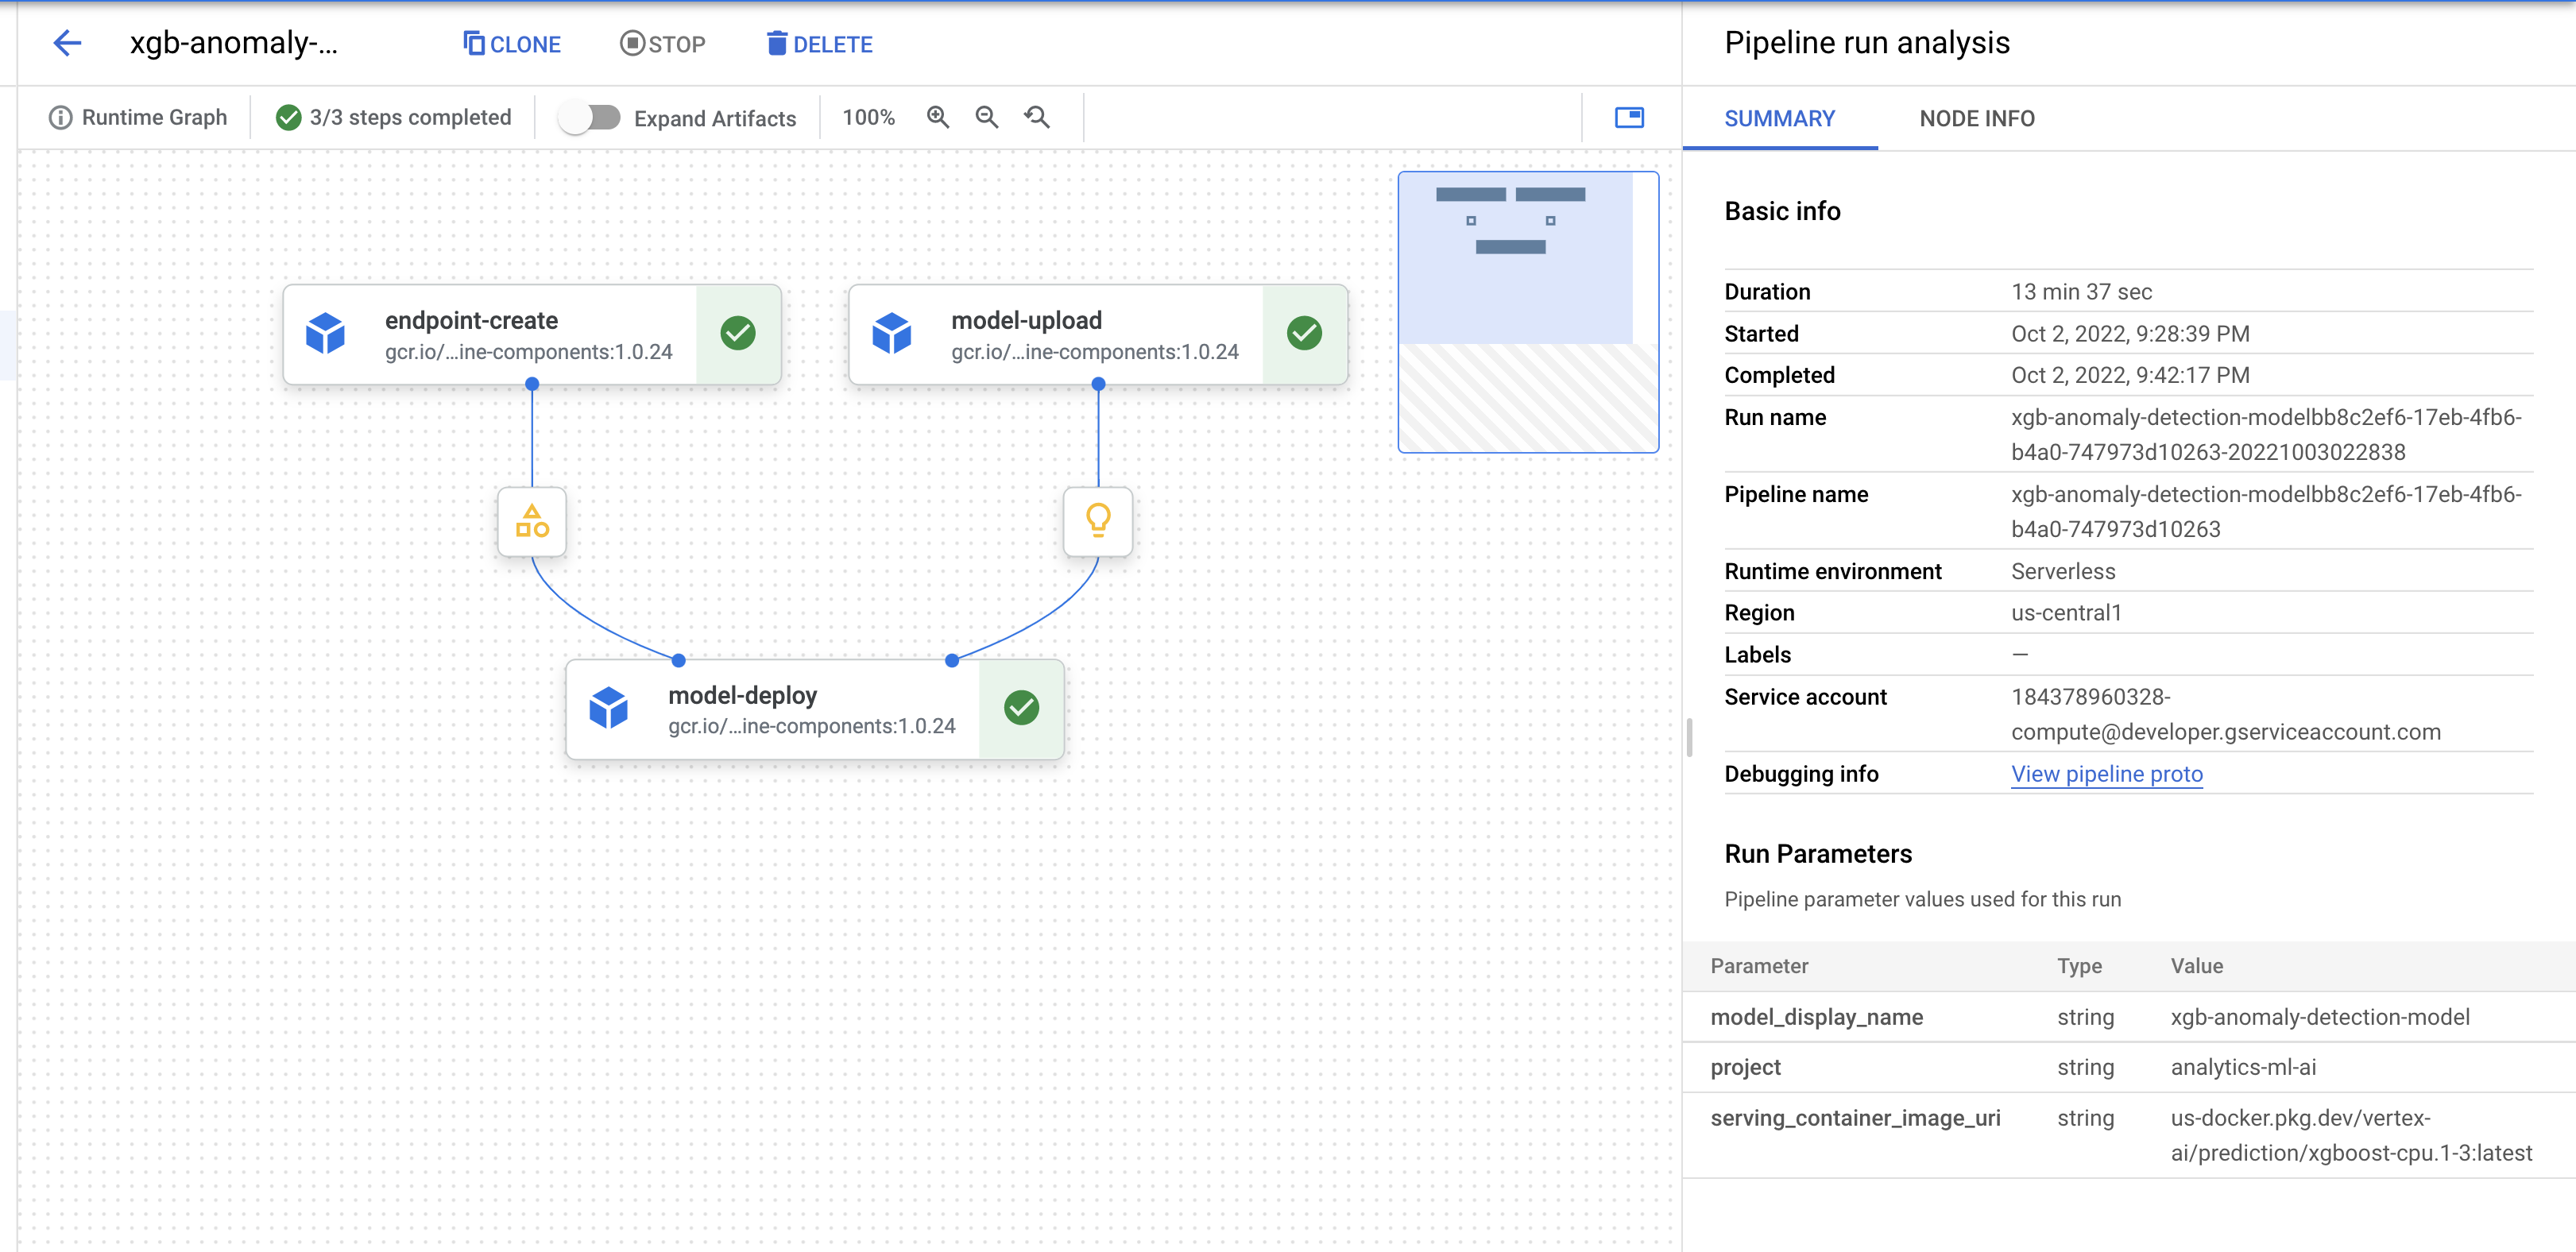